# Renfrewshire Food Hygiene Data Analysis

## Setup

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from os import getcwd

# Configure plots
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (15, 9)

# Connect to the SQLite database
home_path = getcwd()
print(home_path)
conn = sqlite3.connect("/mnt/d/renfrewshire_business_insights/data/renfrewshire_hygiene.db") #adjust path accordingly

/mnt/d/renfrewshire_business_insights/reports


## Overview of Data

In [2]:
#Initial scoping of the SQL database to confirm all is working well
#List all entries
df = pd.read_sql_query("SELECT * FROM establishments;", conn)
df.head(10)

,FHRSID,LocalAuthorityBusinessID,BusinessName,BusinessType,BusinessTypeID,AddressLine1,AddressLine2,AddressLine3,AddressLine4,PostCode,...,LocalAuthorityCode,LocalAuthorityName,LocalAuthorityWebSite,LocalAuthorityEmailAddress,Scores,SchemeType,NewRatingPending,Longitude,Latitude,Geocode
0,1225663,79796,# Bar,Pub/bar/nightclub,7843,Units A And B,16 New Street,Paisley,Renfrewshire,PA1 1XY,...,788,Renfrewshire,http://www.renfrewshire.gov.uk/foodhygieneinfo...,b-serv.es@renfrewshire.gov.uk,None,FHIS,False,-4.426626,55.844654,None
1,136016,70018,102 Field Squadron,Restaurant/Cafe/Canteen,1,Main Buildings Ta Centre,65 Hawkhead Road,Paisley,Renfrewshire,PA1 3NE,...,788,Renfrewshire,http://www.renfrewshire.gov.uk/foodhygieneinfo...,b-serv.es@renfrewshire.gov.uk,None,FHIS,False,-4.398566,55.843739,None
2,459665,74595,1a Wok,Takeaway/sandwich shop,7844,None,28-30 Greenock Road,Bishopton,Renfrewshire,PA7 5JN,...,788,Renfrewshire,http://www.renfrewshire.gov.uk/foodhygieneinfo...,b-serv.es@renfrewshire.gov.uk,None,FHIS,False,-4.510428,55.909986,None
3,1559378,83646,21 Grains,Retailers - other,4613,None,30 Church Street,Lochwinnoch,Renfrewshire,PA12 4AD,...,788,Renfrewshire,http://www.renfrewshire.gov.uk/foodhygieneinfo...,b-serv.es@renfrewshire.gov.uk,None,FHIS,False,-4.6290181,55.7943695,None
4,1693818,83472,328 Asian Style Ltd,Takeaway/sandwich shop,7844,None,38 St James Street,Paisley,Renfrewshire,PA3 2JR,...,788,Renfrewshire,http://www.renfrewshire.gov.uk/foodhygieneinfo...,b-serv.es@renfrewshire.gov.uk,None,FHIS,False,-4.429109,55.848613,None
5,1622790,84048,A & A @ Gary Semples,Takeaway/sandwich shop,7844,Units 1 And 2 Quarrelton,Beith Road,Johnstone,Renfrewshire,PA5 8LF,...,788,Renfrewshire,http://www.renfrewshire.gov.uk/foodhygieneinfo...,b-serv.es@renfrewshire.gov.uk,None,FHIS,False,-4.5110934,55.8295789,None
6,1769927,85216,A & A Bakers,Restaurant/Cafe/Canteen,1,None,9 St James Street,Paisley,Renfrewshire,PA3 2HL,...,788,Renfrewshire,http://www.renfrewshire.gov.uk/foodhygieneinfo...,b-serv.es@renfrewshire.gov.uk,None,FHIS,False,-4.426984,55.848098,None
7,1343437,81485,A & A Paisley Ltd,Manufacturers/packers,7839,Unit 27 Mossedge Industrial Estate,Moss Road,Linwood,Paisley,PA3 3HR,...,788,Renfrewshire,http://www.renfrewshire.gov.uk/foodhygieneinfo...,b-serv.es@renfrewshire.gov.uk,None,FHIS,False,-4.489639,55.851034,None
8,134784,68275,A Bannatyne & Son,Retailers - other,4613,None,118 Paisley Road,Renfrew,Renfrewshire,PA4 8HE,...,788,Renfrewshire,http://www.renfrewshire.gov.uk/foodhygieneinfo...,b-serv.es@renfrewshire.gov.uk,None,FHIS,False,-4.397766,55.871464,None
9,1581537,83730,A Sweeter Side,Other catering premises,7841,None,None,None,None,None,...,788,Renfrewshire,http://www.renfrewshire.gov.uk/foodhygieneinfo...,b-serv.es@renfrewshire.gov.uk,None,FHIS,False,None,None,None


## Top 10 Business Types by Count

/tmp/ipykernel_631/4050437959.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=business_counts, x="Count", y="BusinessType", palette="crest")


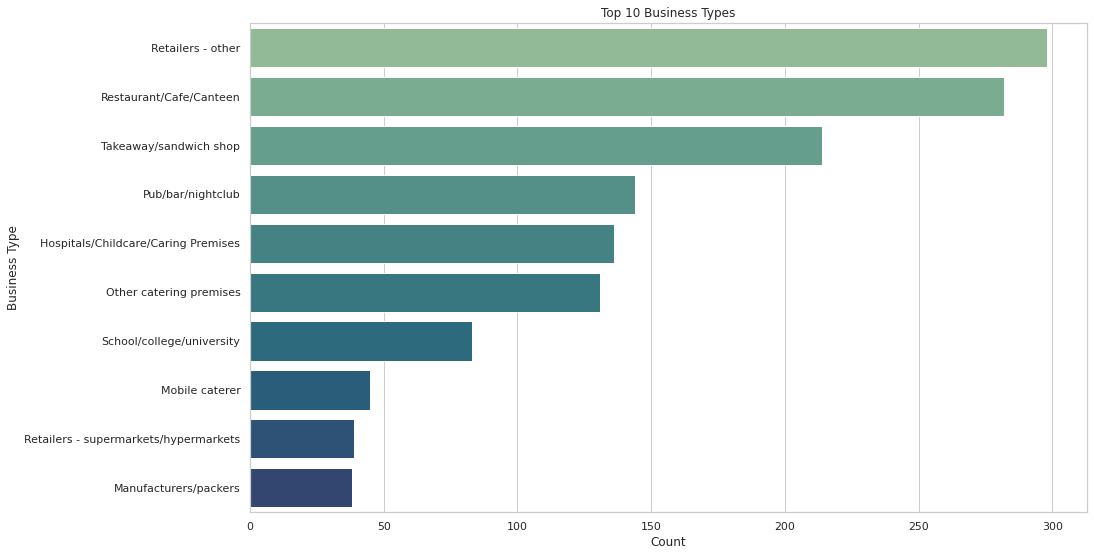

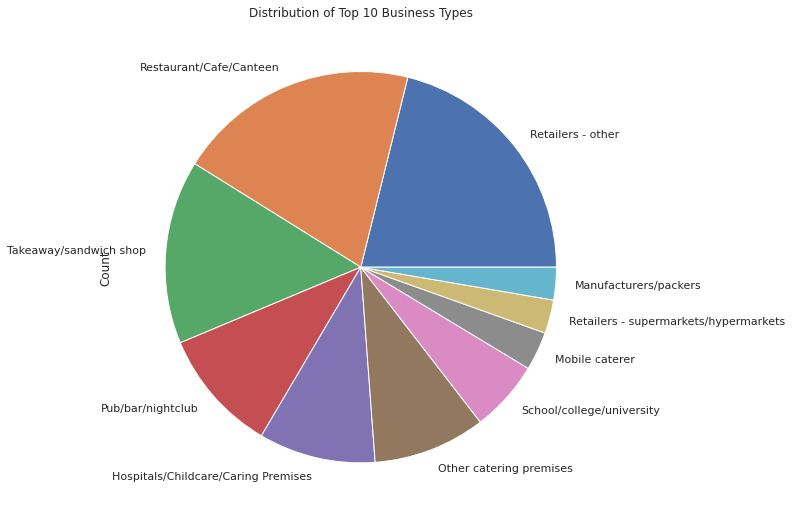

In [3]:
business_counts = pd.read_sql_query("""
SELECT BusinessType, COUNT(*) as Count
FROM establishments
GROUP BY BusinessType
ORDER BY Count DESC
LIMIT 10;
""", conn)

#Plotting
#print(business_counts)
sns.barplot(data=business_counts, x="Count", y="BusinessType", palette="crest")
plt.title("Top 10 Business Types")
plt.xlabel("Count")
plt.ylabel("Business Type")
plt.show()

#Pie chart
business_counts.plot.pie(y = "Count", labels = business_counts["BusinessType"], legend = False)
plt.title("Distribution of Top 10 Business Types")
#plt.xlabel("Rating")
#plt.ylabel("Number of Establishments")
plt.show()



## Hygiene Score Distribution

            RatingValue  Count
0                  Pass   1285
1                Exempt    115
2   Awaiting Inspection     39
3  Improvement Required     14
4     Pass and Eat Safe     12
Total counts is:  1465


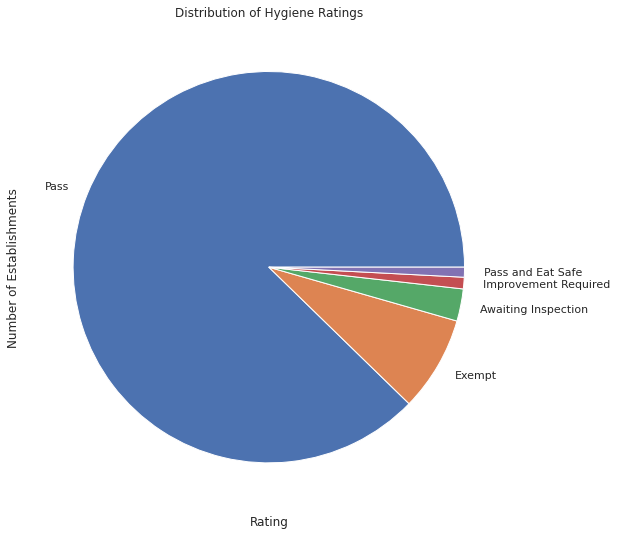

In [4]:
# Get rating value counts
rating_counts = pd.read_sql_query("""
SELECT RatingValue, COUNT(*) as Count
FROM establishments
GROUP BY RatingValue
ORDER BY Count DESC
""", conn)

# Plot
print(rating_counts) # print the data frame
total = rating_counts["Count"].sum()
print("Total counts is: ", total)

rating_counts.plot.pie(y = "Count", labels = rating_counts["RatingValue"], legend = False)
plt.title("Distribution of Hygiene Ratings")
plt.xlabel("Rating")
plt.ylabel("Number of Establishments")
plt.show()

## Deep dive into hygiene ratings

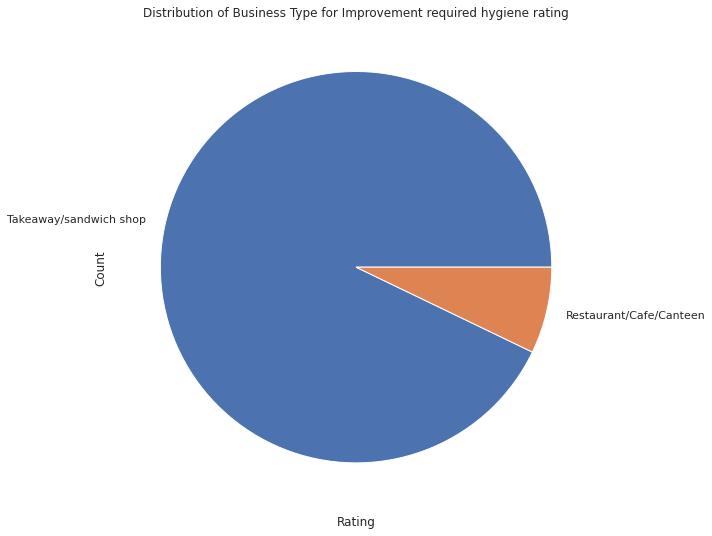

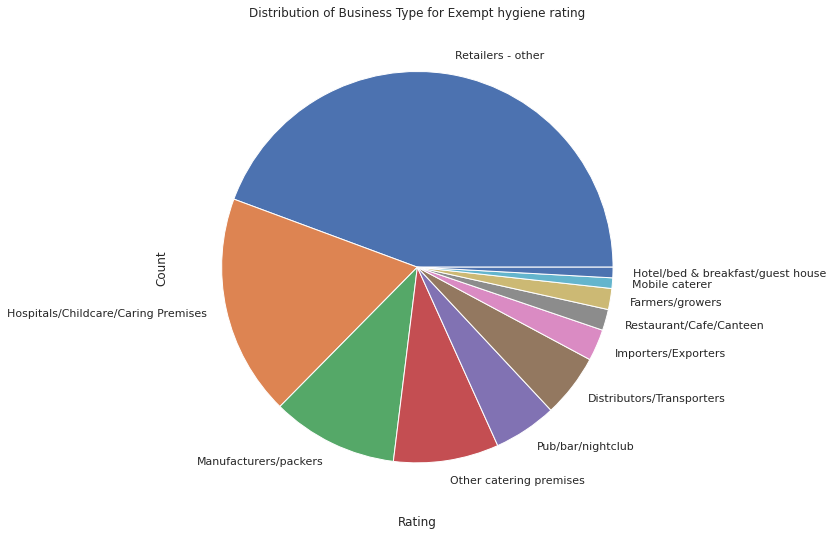

In [5]:
#Get the improvement required ratings along with various parameters
improvement_required = pd.read_sql_query("""
SELECT RatingValue, BusinessType, COUNT(*) as Count
FROM establishments
WHERE RatingValue = 'Improvement Required'
GROUP BY BusinessType
ORDER BY Count DESC;
""", conn)

#Print
#print(improvement_required) # print the data frame

#Plotting
improvement_required.plot.pie(y = "Count", labels = improvement_required["BusinessType"], legend = False)
plt.title("Distribution of Business Type for Improvement required hygiene rating")
plt.xlabel("Rating")
#plt.ylabel("Number of Establishments")
plt.show()

#Get the Exempt ratings along with various parameters
exempt = pd.read_sql_query("""
SELECT RatingValue, BusinessType, COUNT(*) as Count
FROM establishments
WHERE RatingValue = 'Exempt'
GROUP BY BusinessType
ORDER BY Count DESC;
""", conn)

#Print
#print(exempt) # print the data frame

#Plotting
exempt.plot.pie(y = "Count", labels = exempt["BusinessType"], legend = False)
plt.title("Distribution of Business Type for Exempt hygiene rating")
plt.xlabel("Rating")
#plt.ylabel("Number of Establishments")
plt.show()

#Calculations using the global data frame
takeaway = df[df["BusinessType"] == "Takeaway/sandwich shop"]
#takeaway.head(10)


We can see that the majority of businesses that received an 'Improvement Required' score are classified as Takeawy/sandwich shop. It should be noted that Takeaway/sandwich shops take up a large proportion of the dataset but when comapred to the Restaurant/Cafe/Canteen category they are behind in food hygiene rating.

For the Exempt status we see a wide variety of business types. Exempt status is granted for businesses that don't produce their own food but do sell pre-packaged products and medicines which is corroborated here: https://essentialfoodhygiene.co.uk/what-are-the-three-food-hygiene-ratings-for-scotland/. This would explain large section being retailers - other.

## Businesses by Post Code

Using the intial part of a UK postcode, an indication of geographical area can be found. Lets find how many business fit in these areas.

/tmp/ipykernel_631/1281992805.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=business_by_area, x="Number of businesses", y="PartPostCode", palette="crest")


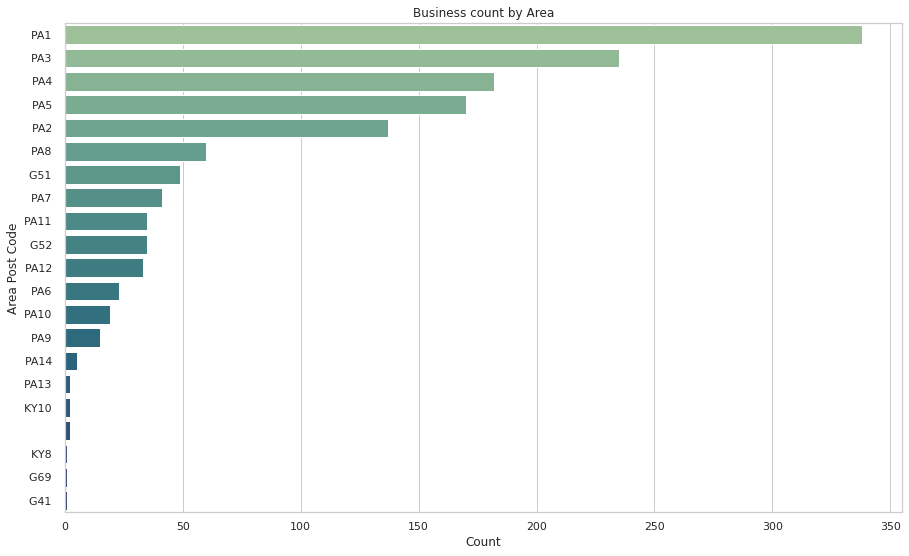

In [6]:
business_by_area = pd.read_sql_query("""
SELECT COUNT(*) as "Number of businesses", SUBSTR(PostCode, 1, instr(PostCode, ' ')) as PartPostCode
FROM establishments
GROUP BY PartPostCode
ORDER BY "Number of businesses" DESC;
""", conn)

#print(business_by_area)
sns.barplot(data=business_by_area, x="Number of businesses", y="PartPostCode", palette="crest")
plt.title("Business count by Area")
plt.xlabel("Count")
plt.ylabel("Area Post Code")
plt.show()



## Map business location data using Geopandas

Using a shapefile for the local authority boundaries from the Improvement Service, the business location data can be placed on a map.

"The dataset is provided under Open Government Licence (OGL) for download and use. You are free to copy, publish, distribute and transmit the information as long as you acknowledge the source as coming from Improvement Service under OGL."

['local_auth', 'code', 'hectares', 'geometry']
All available authority names: 
['Angus' 'Clackmannanshire' 'Dundee City' 'East Ayrshire'
 'East Dunbartonshire' 'East Renfrewshire' 'Falkirk' 'Glasgow City'
 'Inverclyde' 'Midlothian' 'North Lanarkshire' 'Perth and Kinross'
 'Renfrewshire' 'Scottish Borders' 'South Lanarkshire' 'Stirling'
 'West Dunbartonshire' 'West Lothian' 'Highland' 'Moray' 'Orkney Islands'
 'Argyll and Bute' 'Aberdeenshire' 'Fife' 'Aberdeen City'
 'City of Edinburgh' 'East Lothian' 'Shetland Islands' 'North Ayrshire'
 'Dumfries and Galloway' 'South Ayrshire' 'Na h-Eileanan an Iar']


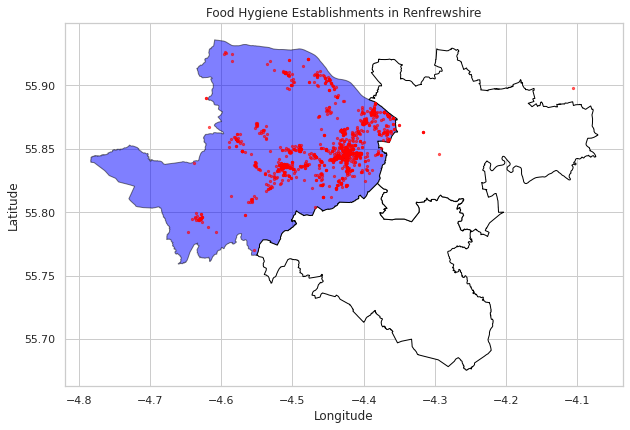

In [7]:
import geopandas as gpd

#Get dataframe with outlier postcodes removed
df_geo = pd.read_sql_query("""
SELECT BusinessName, BusinessType, RatingValue, SUBSTR(PostCode, 1, instr(PostCode, ' ')) as PartPostCode, Longitude, Latitude 
FROM establishments
WHERE PartPostCode LIKE 'PA%' OR PartPostCode LIKE 'G%';
""", conn)

#Load Scottish local authority boundaries
la_gdf = gpd.read_file("/mnt/d/renfrewshire_business_insights/data/pub_las.shp") #local authority GeoDataFrame

print(la_gdf.columns.tolist()) #print all available columns in the GeoDataFrame
print("All available authority names: ") #Check all available authority names
print(la_gdf["local_auth"].unique())  # Optional: inspect names

#Filter for Renfrewshire, East Renfrewshire and Glasgow City
ren_gdf = la_gdf[la_gdf["local_auth"] == "Renfrewshire"].copy()
east_ren_gdf = la_gdf[la_gdf["local_auth"] == "East Renfrewshire"].copy()
glasgow_gdf = la_gdf[la_gdf["local_auth"] == "Glasgow City"].copy()

#Filter out null coordinates from the hygiene dataframe
df_geo = df_geo[df_geo['Latitude'].notnull() & df_geo['Longitude'].notnull()]

#Convert DataFrame to GeoDataFrame
points_gdf = gpd.GeoDataFrame(
    df_geo,
    geometry=gpd.points_from_xy(df_geo.Longitude.astype(float), df_geo.Latitude.astype(float)),
    crs="EPSG:4326"
)

#Ensure CRS matches
ren_gdf = ren_gdf.to_crs(epsg=4326)
east_ren_gdf = east_ren_gdf.to_crs(epsg=4326)
glasgow_gdf = glasgow_gdf.to_crs(epsg=4326)

#Plotting
fig, ax = plt.subplots(figsize=(10, 10))
ren_gdf.plot(ax=ax, color='blue', edgecolor='black', alpha = 0.5)
east_ren_gdf.plot(ax=ax, color='white', edgecolor='black')
glasgow_gdf.plot(ax=ax, color='white', edgecolor='black')
points_gdf.plot(ax=ax, markersize=5, alpha=0.6, color='red')
plt.title("Food Hygiene Establishments in Renfrewshire")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

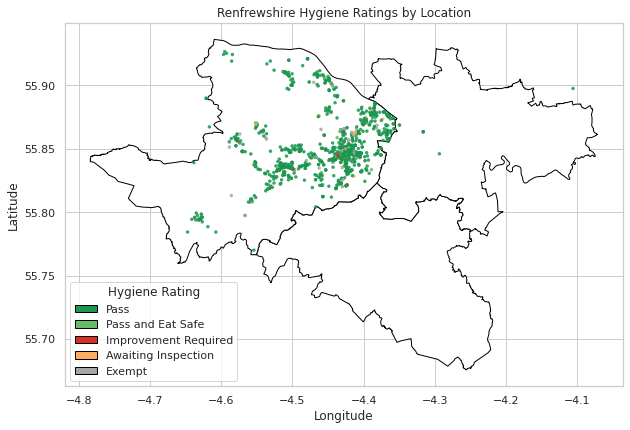

In [8]:
#Generate the local authority boundaries to a single GeoDataFrame
included_areas = ["Renfrewshire", "East Renfrewshire", "Glasgow City"]
boundary_gdf = la_gdf[la_gdf["local_auth"].isin(included_areas)].copy() #boundary dataframe
boundary_gdf = boundary_gdf.to_crs(epsg=4326) #covnert to consitent CRS

# Map each string rating to a colour
rating_colors = {
    "Pass": "#1a9850",                # green
    "Pass and Eat Safe": "#66bd63",   # light green
    "Improvement Required": "#d73027",# red
    "Awaiting Inspection": "#fdae61", # orange
    "Exempt": "#a6a6a6"               # grey
}

#Create a legend for the plot
legend_elements = [
    Patch(facecolor=color, edgecolor='black', label=label)
    for label, color in rating_colors.items()
]

# Map rating to colours by adding a colour column to the dataframe
points_gdf["color"] = points_gdf["RatingValue"].map(rating_colors)

# #Diagnostics
# print(points_gdf[["Longitude", "Latitude", "geometry"]].head())
# print(points_gdf.geom_type.unique())
# print(points_gdf.crs)              

#Plot
fig, ax = plt.subplots(figsize=(10, 10))
boundary_gdf.plot(ax=ax, color="white", edgecolor="black")
points_gdf.plot(ax=ax, markersize=6, color=points_gdf["color"], alpha=0.8)

plt.title("Renfrewshire Hygiene Ratings by Location")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.legend(handles=legend_elements, title="Hygiene Rating", loc='lower left')
plt.show()


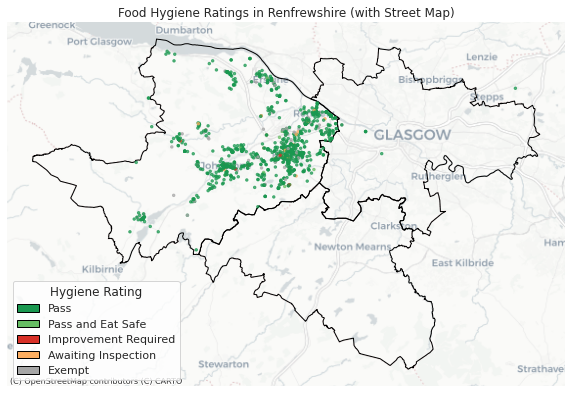

In [17]:
#Use contextily to plot street map underneath plots
import contextily as ctx

#Reproject both GeoDataFrames to EPSG:3857 (Web Mercator)
points_web = points_gdf.to_crs(epsg=3857)
boundary_web = boundary_gdf.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 10))

#Plot boundary outline
boundary_web.plot(ax=ax, color='none', edgecolor='black')
points_web.plot(ax=ax, markersize=6, color=points_web['color'], alpha=0.7) #Plot hygiene points (coloured by rating, as before)

#Add basemap tiles
#ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik) #OpenMap full colour
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron) #grayscale overlay

plt.title("Food Hygiene Ratings in Renfrewshire (with Street Map)")
plt.axis("off")
plt.legend(handles=legend_elements, title="Hygiene Rating", loc='lower left')
plt.show()

## Interactive map using folium based explore method for GeoPandas

In [38]:
points_web.explore(
    column = "BusinessType",
    #tooltip= "BusinessType",                
    tiles = "CartoDB  positron",
    popup = True,
    cmap = "Set1"
)


### Outliers

There are three postcodes that start in KY, which is not a post code in the vicinity of Renfrewshire. We can look at these results more closely to determine why this could be.

In [ ]:
#Will include a map using their lat and long data to show they are based in East Scotland
outliers = pd.read_sql_query("""
SELECT BusinessName, BusinessType, PostCode, AddressLine1,
AddressLine2, AddressLine3, AddressLine4
FROM establishments
WHERE PostCode LIKE "KY%";
""", conn)

outliers.head()

Two of the results are mobile caterers which could explain the lack of a business address within the confines of Renfrewshire. 

## Save and Close

In [ ]:
conn.close()